# How Do We Learn the Wave Equation?

In [2]:
import sys
if True: # On colab
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)
    root = "/content/drive/My Drive/Colab Notebooks/omega/"
    sys.path.append("/content/drive/My Drive/Colab Notebooks/omega/")
else: # Local
    root = './'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!pip3 install cmocean
!pip3 install git+https://github.com/rtqichen/torchdiffeq
!pip3 install detest

     |████████████████████████████████| 225kB 2.8MB/s 
  Cloning https://github.com/rtqichen/torchdiffeq to /tmp/pip-req-build-2no8yb7a
  Running command git clone -q https://github.com/rtqichen/torchdiffeq /tmp/pip-req-build-2no8yb7a
  Created wheel for torchdiffeq: filename=torchdiffeq-0.0.1-cp36-none-any.whl size=25885 sha256=4178ab5b43b5d880156901fc5d5c19b79ee5840bcd5adde63b11468ffc72b0e4
  Stored in directory: /tmp/pip-ephem-wheel-cache-gzxfmlei/wheels/3f/76/69/01867bf3355c3bc8bae7e556b17b44c395b6cda5e76fd8ddc7
Successfully built torchdiffeq


In [0]:
import numpy as np
from matplotlib import pylab as plt
import matplotlib.animation as animation
import cmocean, seaborn

In [0]:
import utils, plotting, helper, models, ode_helper, \
        analytical_solutions
# Hack for reloading in notebooks without reseting the kernel
import importlib
importlib.reload(utils)
importlib.reload(helper)
importlib.reload(plotting)
importlib.reload(models)
importlib.reload(ode_helper)
importlib.reload(analytical_solutions)

from helper import *
from utils import *
from analytical_solutions import *
from ode_helper import *

In [6]:
device=get_device()
set_seed()

Connected to a GPU


We can generate any dataset that we want with the analytical solution.

In [7]:
ts, data = make_wave_dataset(10, 500, t_max=83,
                             params=WAVE_PARAMS[1])
torch_data = data_to_torch(data, device=device)
torch_ts = data_to_torch(ts, device=device)
NT,_,NX = data.shape
dt = ts[1]-ts[0]

[0.19350920659919693, -0.024188650824899606, 0.007167007651822101, -0.0030235813531124464, 0.0015480736527935708, -0.0008958759564777596, 0.0005641667830880341, -0.00037794766913905347, 0.00026544472784526056, -0.00019350920659919448, 0.00014538633102868976, -0.00011198449455971839, 8.807883777842609e-05, -7.052084788600294e-05, 5.733606121457203e-05, -4.724345864238052e-05, 3.9387178220883785e-05, -3.318059098065654e-05, 2.8212451756695488e-05, -2.418865082489838e-05]


We want to learn the true operator, and we'll try multiple strategies to do so:
1. Optimize Omega and take the matrix log
2. Add an elastic net to Omega, and take the matrix log
3. Learn a model in an ODE solver, and hope the model is Lambda
4. Use the mixed ODE-loss, and hypothesize that prevents overfitting.

In [0]:
class Experiment():
    """
    This is an awkward container class to store experiment
    results in this notebook.
    """
    def __init__(self, ode=False,methods=('euler',)):
        self.ode = ode
        self.methods=methods
        if ode:

            self.model = models.MultiLinearODE((2,NX),(2,NX),bias=False).double().to(device)
        else:
            self.model = models.MultiLinear((2,NX),(2,NX),bias=False).double().to(device)
        # This is the awkard state
        self.losses = np.array([])
        self.callback = lambda m,o,l : self._callback(m,o,l)
        self.save_schedule = [2.0**-i for i in range(-1,100)]
        self.next_save = self.save_schedule.pop(0)
        self.all_omegas = []
        self.all_metrics = []
        
    def _callback(self, model, opt_iter, loss):
        if loss < self.next_save:
            Om = self.model.net.weight.detach().cpu().numpy().copy()
            self.all_omegas.append(Om)
            self.all_metrics.append((opt_iter,loss))
            print("Saving at ",opt_iter, " with loss ",loss)
            self.next_save = self.save_schedule.pop(0)
            
    def train(self,N_iter=10000,gamma_L1=0,gamma_L2=0,
              learning_rate=1.0e-4):
              
        _,losses = learn_rnn(torch_data, self.model,
            N_iter=N_iter,batch_size=250,
            N_print=100, callback=self.callback,
            learning_rate=learning_rate,
            gamma_L1 = gamma_L1, gamma_L2 = gamma_L2, device=device)
        self.losses = np.append(self.losses,losses)

    def train_ode(self,N_iter=10000,gamma_L1=0,gamma_L2=0,
                  learning_rate=1.0e-4):
        _,losses = train_a_neural_ode_multi_method(torch_data, torch_ts,
                                                   self.model,
                                                   batch_size=250,
                                                   learning_rate=learning_rate,
                                                   methods=self.methods,
                                                   callback=self.callback,
                                                   N_iter=N_iter,
                                                   device=device)
        self.losses = np.append(self.losses,losses)

    def post(self):
        if not self.ode:
            self.np_omegas = np.array(self.all_omegas)
            self.UVs = [helper.integrate_matrix(self.np_omegas[i,:,:],
                                    torch_data[0:1,:,:].cpu().numpy(), 25 )
                        for i in range(self.np_omegas.shape[0]) ]
            self.all_lambdas = [ lambda_of_omega(om,dt) 
                                for om in self.all_omegas ]
            self.np_lambdas = np.array(self.all_lambdas)
        else:
            self.all_lambdas = self.all_omegas
            self.np_lambdas = np.array(self.all_lambdas)

    def make_animation(self,interval=1,transpose=False):
        img = self.np_omegas
        metrics = self.all_metrics
        UVs = self.UVs
        fig, ax = plt.subplots(figsize=(6,3))
        minmax = np.max(np.abs(img)) * 0.65
        tr = lambda x : x.T if transpose else x
        ax_left = plt.subplot(1,2,1)
        ax_left.set_title(f"Iteration #{metrics[0][0]}     Loss = {metrics[0][1]:1.2e}")
        canvas = plt.imshow(tr(img[0,:,:]), interpolation='none',
                            cmap=cmocean.cm.balance, 
                            #interpolation='bicubic', 
                            vmin=-minmax, vmax=minmax)
        plt.axis('off')
        plt.text(-3,5,'$\\frac{du}{dt}$',fontsize=16)
        plt.text(-3,15,'$\\frac{dv}{dt}$',fontsize=16)
        plt.text(5,21,'$u$')
        plt.text(15,21,'$v$')
        ax = plt.subplot(1,2,2)
        ax.set_ylim((-0.5, 0.5))
        ax.set_title("$u(x,t)$")
        xs = np.linspace(0,1,UVs[0].shape[-1])
        line, = ax.plot(xs,UVs[0][0,0,:], lw=2)
        plt.tight_layout()
        def animate(i):
            frame = i//UVs[0].shape[0]
            time = i%UVs[0].shape[0]
            ax_left.set_title(f"Iteration #{metrics[frame][0]}     Loss = {metrics[frame][1]:1.2e}")
            line.set_data(xs,UVs[frame][time,0,:])
            canvas.set_array(tr(img[frame,:,:]))
            return canvas,
        ani = animation.FuncAnimation(fig, animate, frames=img.shape[0]*UVs[0].shape[0],
                                      interval = interval)
        return ani

In [0]:
experiments = {
    "Naive":Experiment(),
    "Elastic":Experiment(),
    "ODE_Euler":Experiment(ode=True),
    "ODE_Multi2":Experiment(ode=True,methods=('euler','midpoint','rk4')),
    "ODE_Multi3":Experiment(ode=True,methods=('midpoint','rk4')),
}

In [0]:
N_iter = 50000
experiments["Naive"].train(N_iter=N_iter)
experiments["Elastic"].train(N_iter=N_iter,gamma_L1=1.0e-5,gamma_L2=1.0e-7)
experiments["ODE_Euler"].train_ode(N_iter=N_iter,learning_rate=1e-2)
experiments["ODE_Multi3"].train_ode(N_iter=N_iter,learning_rate=1e-2,)
experiments["ODE_Multi2"].train_ode(N_iter=N_iter,learning_rate=1e-2,)

Saving at  99  with loss  0.25358743261822864
Saving at  199  with loss  0.19538690118790222
Saving at  299  with loss  0.18734984457622886
Saving at  399  with loss  0.1552911449361787
Saving at  599  with loss  0.10987397529600162
Saving at  999  with loss  0.05860648197204039
Saving at  1499  with loss  0.028775152503076943
Saving at  1999  with loss  0.014151594173061551
Saving at  2599  with loss  0.006964576714131959
Saving at  3499  with loss  0.0035740815149762
Saving at  5799  with loss  0.0019482638336600585
Saving at  8099  with loss  0.0009239847199513148
Saving at  9899  with loss  0.0004819483242719247
Saving at  12299  with loss  0.00022342218477435432
Saving at  15499  with loss  0.00012106380506662474
Saving at  18699  with loss  6.023891800433586e-05
Saving at  22399  with loss  2.9672155501320282e-05
Saving at  27499  with loss  1.5131376139021205e-05
Saving at  34799  with loss  7.517115673079844e-06
Saving at  46799  with loss  3.6993337628487628e-06
Saving at  99 

In [0]:
for n,exp in experiments.items():
    try:
        exp.post()
        plt.figure(figsize=(12,4))
        plt.title(n)
        plt.subplot(1,2,1)
        seaborn.heatmap(exp.all_lambdas[-1], cmap='RdBu', center=0, vmin=-10,vmax=10)
        plt.subplot(1,2,2)
        seaborn.heatmap(exp.all_omegas[-1], cmap='RdBu', center=0, vmin=-2,vmax=2)
        plt.show()
    except:
        print("Skipping ",n)

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


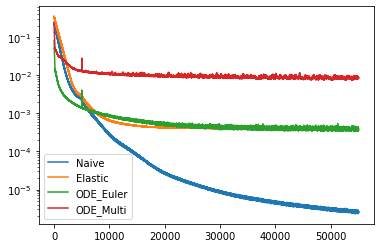

In [55]:
for n,exp in experiments.items():
    try:
        plt.semilogy(exp.losses,'-',label=n)
    except:
        print("Skipping ",n)
plt.legend()

## Hyperparamter test:

It turns out that the ODE methods need learning rates with a different tuning.

In [0]:
LR_HYPER = { k:Experiment(ode=True) for k in [1.0e-2,1.0e-3,5.0e-4,1.0e-4,5.0e-5]}
for k,exp in LR_HYPER.items():
    exp.train_ode(N_iter=N_iter,learning_rate=k)

Saving at  4999  with loss  0.0033781249080902555
Saving at  4999  with loss  0.0033781249080902555
Saving at  4999  with loss  0.008240142868344312
Saving at  4999  with loss  0.008240142868344312
Saving at  4999  with loss  0.011062169444927545
Saving at  4999  with loss  0.011062169444927545
Saving at  4999  with loss  0.038727107219752685
Saving at  4999  with loss  0.038727107219752685
Saving at  4999  with loss  0.05020319540402678
Saving at  4999  with loss  0.05020319540402678


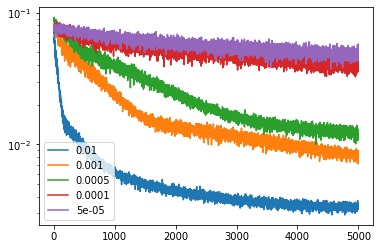

In [0]:
for n,exp in LR_HYPER.items():
    try:
        plt.semilogy(exp.losses,'-',label=n)
    except:
        print("Skipping ",n)
plt.legend()

In [12]:
for n,exp in LR_HYPER.items():
    try:
        exp.post()
        plt.figure()
        plt.title(n)
        seaborn.heatmap(exp.all_lambdas[-1], cmap='RdBu', center=0)
    except:
        print("Skipping ",n)

NameError: ignored